# Covid-19 Radiology Segmentation & Classification
COMP 478 Project
<br>
Jeremy Gaudet
<br>
ID: 40045224
<br>
April 25, 2021

In [47]:
import tensorflow as tf
from tensorflow import keras
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
from PIL import Image
from datetime import datetime
import io

import sys
import os
from glob import glob

In [48]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# sys.path.append('/content/gdrive/My Drive/COMP478 Project/')
# %cd /content/gdrive/My Drive/COMP478 Project/

## Global variables

In [49]:
PATH = '/Users/jeremygaudet/Downloads/COVID-19_Radiography_Dataset'
BATCH_SIZE = 32
IMAGE_SIZE = (128, 128)
IMAGE_WIDTH = IMAGE_SIZE[0]
IMAGE_HEIGHT = IMAGE_SIZE[1]
NUM_CLASSES = 4

## Loading the images

In [50]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 21165 files belonging to 4 classes.
Using 16932 files for training.


In [51]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 21165 files belonging to 4 classes.
Using 4233 files for validation.


In [52]:
CLASS_NAMES = train_ds.class_names
print(CLASS_NAMES)

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


# Data Analysis

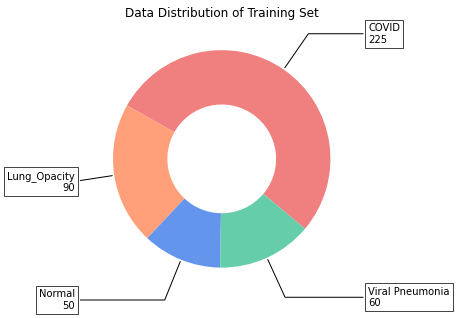

In [53]:
def display_distribution_donut():
    fig, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(aspect="equal"))

    data = [225, 90, 50, 60]

    wedges, texts = ax.pie(
        data, 
        wedgeprops=dict(width=0.5), 
        startangle=-40, 
        colors=['lightcoral','lightsalmon', 'cornflowerblue', 'mediumaquamarine'])

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
            bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(f'{CLASS_NAMES[i]}\n{data[i]}', xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)

    ax.set_title("Data Distribution of Training Set")
    plt.show()

display_distribution_donut()

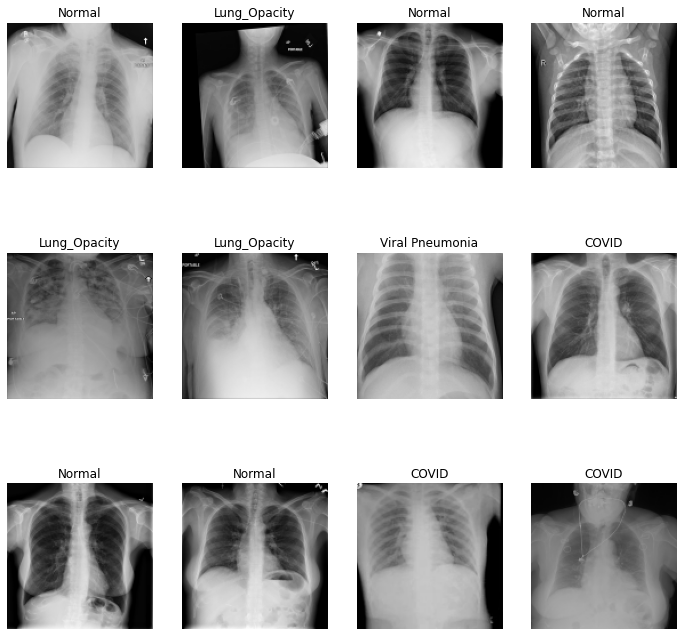

In [54]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(CLASS_NAMES[labels[i]])
        plt.axis("off")

In [55]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break


(32, 128, 128, 3)
(32,)


# Image Processing

In [56]:
from keras import layers

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMAGE_HEIGHT, 
                                                              IMAGE_WIDTH,
                                                              3)),
    # layers.experimental.preprocessing.RandomRotation(0.01),
    # layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

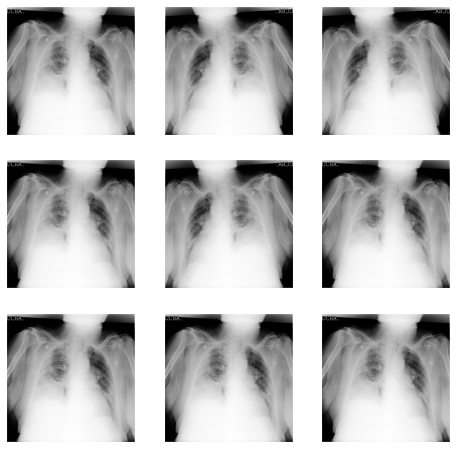

In [57]:
plt.figure(figsize=(8, 8))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"), cmap="gray")
        plt.axis("off")

# Classification

In [58]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [59]:
model = tf.keras.Sequential([ 
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'), # was 32
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'), # 32
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'), # 128
    layers.Dense(NUM_CLASSES)
])

In [60]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 128, 128, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 128)      

In [61]:
hist = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
530/530 [==============================] - 67s 126ms/step - loss: 0.9303 - accuracy: 0.6254 - val_loss: 0.6094 - val_accuracy: 0.7626
Epoch 2/10
530/530 [==============================] - 63s 119ms/step - loss: 0.5443 - accuracy: 0.7892 - val_loss: 0.5184 - val_accuracy: 0.8072
Epoch 3/10
530/530 [==============================] - 62s 118ms/step - loss: 0.4508 - accuracy: 0.8258 - val_loss: 0.4899 - val_accuracy: 0.8209
Epoch 4/10
530/530 [==============================] - 62s 118ms/step - loss: 0.3847 - accuracy: 0.8500 - val_loss: 0.4585 - val_accuracy: 0.8330
Epoch 5/10
530/530 [==============================] - 62s 118ms/step - loss: 0.3438 - accuracy: 0.8699 - val_loss: 0.4122 - val_accuracy: 0.8516
Epoch 6/10
530/530 [==============================] - 64s 121ms/step - loss: 0.3128 - accuracy: 0.8824 - val_loss: 0.3854 - val_accuracy: 0.8620
Epoch 7/10
530/530 [==============================] - 63s 119ms/step - loss: 0.2832 - accuracy: 0.8971 - val_loss: 0.4309 - val_ac

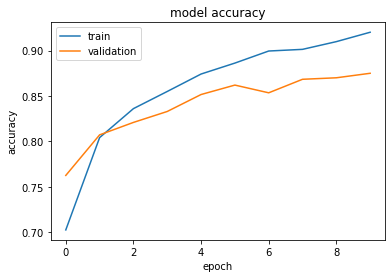

In [62]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)

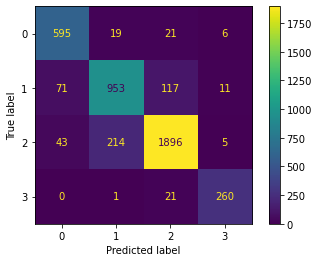


                  precision    recall  f1-score   support

          COVID       0.93      0.84      0.88       709
   Lung_Opacity       0.83      0.80      0.81      1187
         Normal       0.88      0.92      0.90      2055
Viral Pneumonia       0.92      0.92      0.92       282

       accuracy                           0.88      4233
      macro avg       0.89      0.87      0.88      4233
   weighted avg       0.88      0.88      0.87      4233



In [67]:
def validation_data_categories(test_images):
    y_pred = model.predict(test_images)
    predicted_cat = tf.argmax(y_pred, axis=1)
    true_cat = tf.concat([y for x, y in test_images], axis=0)
    return true_cat, predicted_cat

def plot_confusion_matrix(true_cat, predicted_cat):
    cm = confusion_matrix(predicted_cat, true_cat)
    display = ConfusionMatrixDisplay(cm).plot()
    plt.show()

# Show the confusion matrix and the report
true_cat, pred_cat = validation_data_categories(val_ds)
plot_confusion_matrix(true_cat, pred_cat)
print('\n', classification_report(true_cat, pred_cat, target_names=CLASS_NAMES))

This image is Normal with 75.36% confidence


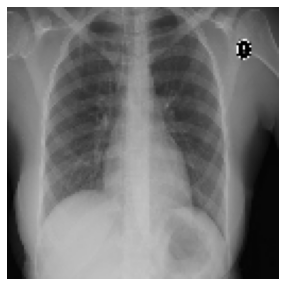

In [64]:
# test_image_path = "/Users/jeremygaudet/Downloads/istockphoto-173883249-612x612.jpg"
# test_image_path = "/Users/jeremygaudet/Downloads/c3-1-e1586266398823.jpg.webp"
test_image_path = "/Users/jeremygaudet/Downloads/normal-lung-xray-15x10-by-Yale-Rosen.jpg"

img = keras.preprocessing.image.load_img(test_image_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

# Plot image
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.axis("off")

# Load a model
# model_256 = keras.models.load_model('models/covid_lung_model_256_preprocess_drop.h5')

# Preprocess image
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
# Make predictions on images
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
# Get index for highest confidence class
idx = np.argmax(score)

print(f'This image is {CLASS_NAMES[idx]} with {score[idx]*100:0.2f}% confidence')

In [65]:
# Save the entire model to a HDF5 file.
# !mkdir models/
# model.save('models/covid_lung_model_256_preprocess_drop_big.h5')